In [108]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import random as rand

Numerically Simulate using Euler-Maruyama scheme

X_new = b(X_old)delta_t + sigma(X_old)del_W

where: delta_t = t_new/n, and delta_W ~ N(0, del_t_)

in this example: b = x - x^3 and sigma = 1/(1+0.3x^2)^2 and X_0 = 1

In [5]:
# params 
run_time = 3.0
n = 300
del_t = run_time/n
num_sims = 1000000

results = np.zeros((num_sims, n))
results[:, 0] = 1.
W = np.random.normal(0, del_t, size=(num_sims, n-1))


In [6]:
for j in range(1, n):
    drift_term = (results[:, j-1] - (results[:, j-1]**3))*del_t
    diffusion_term = 1/(1+ 0.3*(results[:, j-1]**2)**2)
    diffusion_term = diffusion_term*W[:, j-1]
    results[:, j] = results[:, j-1] + drift_term + diffusion_term
print('complete')

complete


In [16]:
y_ax = np.sum(results, axis=0)/num_sims
x_ax = np.arange(start=0, stop=run_time, step=del_t)

<function matplotlib.pyplot.show(close=None, block=None)>

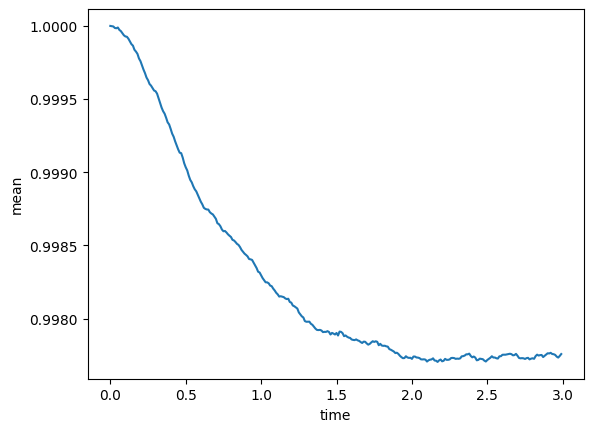

In [8]:
plt.plot(x_ax, y_ax)
plt.xlabel('time')
plt.ylabel('mean')
plt.show

In [9]:
time = results[:, 299]

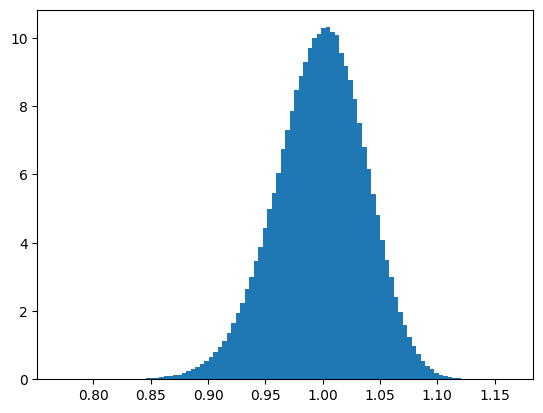

In [10]:
plt.hist(time, bins=100, density=True)
plt.show()

Janky Numeical scheme TDM with first order accuracy in time and second order in space 

In [115]:
#Define b, b' sigma b' and sigma''
def b_func(x):
    return x - (x**3)

def b_prime(x):
    return 1-(3*(x**2))

def sigma(x):
    return 1/((1+0.3*(x**2))**2)

def sigma_prime(x):
    return (-1.2*x)/((1+(0.3*(x**2)))**3)

def sigma_dprime(x):
    first_term = (-2.16*(x**2))/((1+0.3*(x**2))**4)

    second_term = (-1.2)/((1+0.3*(x**2))**3)

    return first_term + second_term

In [116]:
# Define functions for alpha, beta and gamma

def alpha(x):
    return (0.5*sigma_dprime(x)) - b_prime(x)

def beta(x):
    return sigma_prime(x) - b_func(x)

def gamma(x):
    return sigma(x)/2 

# Define coefficent functions
def p_plus(x, del_x, del_t):
    
    first_term = (del_t*beta(x))/(2*del_x)
    second_term = (del_t*gamma(x))/(del_x**2)

    return first_term + second_term

def p_same(x, del_x, del_t):
    return 1 + (del_t*alpha(x)) - (del_t*(2*gamma(x))/(del_x**2))

def p_minus(x, del_x, del_t):

    first_term = del_t*gamma(x)/(del_x**2)
    second_term = (-del_t*beta(x))/(2*del_x)

    return first_term + second_term

In [117]:
#Hyper parameters
num_timesteps = 1000000
gridpoints = 1000
space_interval = (-3, 3)
run_time = 3
del_t = run_time/num_timesteps
del_x = (space_interval[1] - space_interval[0])/gridpoints
results = np.zeros((num_timesteps, gridpoints))
results[0, 500] = 1/del_x

Coefficients have no time dependence so may as well calculate them ahead of time

In [118]:
    
x_ref = np.arange(start = space_interval[0], stop = space_interval[1], step = del_x)

coeff_plus = np.arange(start = space_interval[0], stop = space_interval[1], step = del_x)
coeff_same = np.arange(start = space_interval[0], stop = space_interval[1], step = del_x)
coeff_minus = np.arange(start = space_interval[0], stop = space_interval[1], step = del_x)

coeff_plus = p_plus(coeff_plus, del_x, del_t)
coeff_same = p_same(coeff_same, del_x, del_t)
coeff_minus = p_minus(coeff_minus, del_x, del_t)

In [119]:
for i in range(1, num_timesteps):
    results[i, 1:-1] = results[i-1, 1:-1] + (coeff_plus[1:-1]*results[i-1, 2:]) + (coeff_same[1:-1]*results[i-1, 1:-1])\
    + (coeff_minus[1:-1]*results[i-1, 0:-2])
print('complete')

/tmp/ipykernel_133062/3598063195.py:2: RuntimeWarning: overflow encountered in add
  results[i, 1:-1] = results[i-1, 1:-1] + (coeff_plus[1:-1]*results[i-1, 2:]) + (coeff_same[1:-1]*results[i-1, 1:-1])\
/tmp/ipykernel_133062/3598063195.py:2: RuntimeWarning: invalid value encountered in add
  results[i, 1:-1] = results[i-1, 1:-1] + (coeff_plus[1:-1]*results[i-1, 2:]) + (coeff_same[1:-1]*results[i-1, 1:-1])\


complete


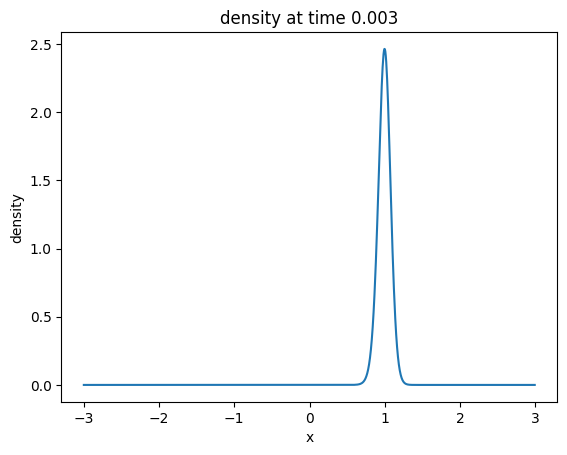

In [134]:
time = 0.003
ind = math.floor(time/del_t)
plt.title(f'density at time {time}')
plt.xlabel('x')
plt.ylabel('density')
plt.plot(x_ref, results[ind, :])

Since the above method appears to be incredibly numerically unstable I am attempting a conservative finite volume method from Chang and Cooper. Here is you do some reaarangement for the forward kolmogrov equation it becomes dp/dt = -d/dx(B(x)p + C(dp/dx)) where B(x) = b(x) - 1/2*sigma_prime(x) and C(x) = -sigma(x)/2

In [126]:
def big_B(x):
    return b_func(x) - (0.5*sigma_prime(x))

def big_C(x):
    return (-sigma(x))/0.5


In [127]:
# Functions to calculate entries in coefficient matrix

"""
# Functions using averaging over gridpoints
def aph(x, d_x, d_t, delta_i, delta_last):
    term_1 = (1/d_x)*((big_C(x+d_x)+big_C(x))*0.5 + big_C(x-(d_x/2)))
    term_2 = (1-delta_last)*((big_B(x-(d_x)) + big_B(x))*0.5)
    term_3 = -delta_i*((big_B(x+d_x) + big_B(x))*0.5)
    return 1 - (d_t/d_x)*(term_1 + term_2 + term_3)

def bta(x, d_x, d_t, delta_i):
    term_1 = (1 - delta_i)*((big_B(x + d_x)+big_B(x))*0.5)
    term_2 = (1/d_x)*((big_C(x + d_x) + big_C(x))*0.5)
    return (d_t/d_x)*(term_1 + term_2)

def gma(x, d_x, d_t, delta_last):
    term_1 = (1/d_x)*((big_C(x - d_x) + big_C(x))*0.5)
    term_2 = -delta_last*(0.5*(big_B(x - d_x) + big_B(x)))
    return (d_t/d_x)*(term_1 + term_2)
"""

# Functions using exact evaluations
def aph(x, d_x, d_t, delta_i, delta_last):
    term_1 = (1/d_x)*(big_C(x+(d_x/2)) + big_C(x-(d_x/2)))
    term_2 = (1-delta_last)*big_B(x-(d_x/2))
    term_3 = -delta_i*big_B(x+(d_x/2)) 
    return 1 - (d_t/d_x)*(term_1 + term_2 + term_3)

def bta(x, d_x, d_t, delta_i):
    term_1 = (1 - delta_i)*big_B(x + (d_x/2))
    term_2 = (1/d_x)*big_C(x + (d_x/2))
    return (d_t/d_x)*(term_1 + term_2)

def gma(x, d_x, d_t, delta_last):
    term_1 = (1/d_x)*big_C(x - (d_x/2))
    term_2 = -delta_last*big_B(x - (d_x/2))
    return (d_t/d_x)*(term_1 + term_2)

In [128]:
# Hyper params
num_timesteps = 10000
gridpoints = 1000
space_interval = (-3, 3)
run_time = 3
del_t = run_time/num_timesteps
del_x = (space_interval[1] - space_interval[0])/gridpoints

# set up coefficient matrix using Dirichlet BCs
coeff_mat = np.zeros((gridpoints, gridpoints))
coeff_mat[0, 0] = 1.
coeff_mat[gridpoints-1, gridpoints-1] = 1.

# grid points and calculated deltas
x_ref = np.arange(start = space_interval[0], stop = space_interval[1], step = del_x)
omega = (del_x*big_B(x_ref + (del_x/2)))/big_C(x_ref + (del_x/2))
delta = (1/omega) - (1/(np.exp(omega)-1))

for i in range(1, gridpoints-1):
    coeff_mat[i, i-1] = gma(x_ref[i], del_x, del_t, delta[i-1])
    coeff_mat[i, i] = aph(x_ref[i], del_x, del_t, delta[i], delta[i-1])
    coeff_mat[i, i+1] = bta(x_ref[i], del_x, del_t, delta[i])

upper_diag = np.diag(coeff_mat, k=1)
diag = np.diag(coeff_mat, k=0)
lower_diag = np.diag(coeff_mat, k=-1)

banded_fmt_coeffs = np.vstack([
    np.append(0, upper_diag), diag, np.append(lower_diag, 0)
])


In [129]:
results = np.zeros((num_timesteps, gridpoints))
results[0, 666:667] = 1/(2*del_x)

for i in range(1, num_timesteps):
    next_time = sp.linalg.solve_banded((1, 1), banded_fmt_coeffs, results[i-1])
    results[i] = next_time
print('complete')

complete


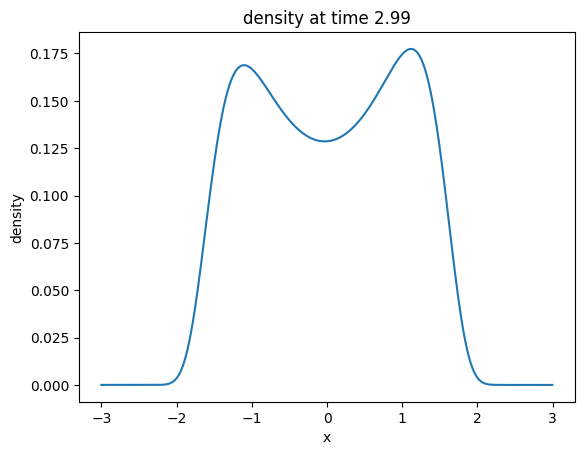

In [135]:
time = 2.99
ind = math.floor(time/del_t)
plt.title(f'density at time {time}')
plt.xlabel('x')
plt.ylabel('density')
plt.plot(x_ref, results[ind, :])

0.0
